In [2]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-03-31 19:10:20'

# wip

In [3]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [5]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [6]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('khurram_temp_exp_4', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)

In [7]:
pd.read_sql(f'select * from runs', db1.conn)

,features,freq,lambda,name,run,seed,start,step_size,steps,width
0,5,1000000,0.990,temp_exp_4,0,0,0,0.0050,5000000,1
1,5,1000000,0.999,temp_exp_4,1,0,0,0.0050,5000000,1
2,5,1000000,0.990,temp_exp_4,2,1,0,0.0050,5000000,1
3,5,1000000,0.999,temp_exp_4,3,1,0,0.0050,5000000,1
4,5,1000000,0.990,temp_exp_4,4,2,0,0.0050,5000000,1
...,...,...,...,...,...,...,...,...,...,...
1195,10,500000,0.999,temp_exp_4,1195,7,0,0.0005,5000000,1
1196,10,500000,0.990,temp_exp_4,1196,8,0,0.0005,5000000,1
1197,10,500000,0.999,temp_exp_4,1197,8,0,0.0005,5000000,1
1198,10,500000,0.990,temp_exp_4,1198,9,0,0.0005,5000000,1


In [8]:
db2 = DbAccessor('khurram_temp_exp_4_tbtt', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

,features,lambda,name,run,seed,step_size,steps,truncation
0,2,0.990,temp_exp_4_tbtt,0,0,0.10,5000000,27
1,2,0.999,temp_exp_4_tbtt,1,0,0.10,5000000,27
2,2,0.990,temp_exp_4_tbtt,2,1,0.10,5000000,27
3,2,0.999,temp_exp_4_tbtt,3,1,0.10,5000000,27
4,2,0.990,temp_exp_4_tbtt,4,2,0.10,5000000,27
...,...,...,...,...,...,...,...,...
995,20,0.999,temp_exp_4_tbtt,995,7,0.05,5000000,27
996,20,0.990,temp_exp_4_tbtt,996,8,0.05,5000000,27
997,20,0.999,temp_exp_4_tbtt,997,8,0.05,5000000,27
998,20,0.990,temp_exp_4_tbtt,998,9,0.05,5000000,27


In [9]:
db3 = DbAccessor('hshah1_0065_animal_learning_ub', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

,features,freq,lambda,name,run,seed,start,step_size,steps,width
0,10,100000000,0.990,0065_animal_learning_ub,0,0,0,0.0050,5000000,10
1,10,100000000,0.999,0065_animal_learning_ub,1,0,0,0.0050,5000000,10
2,10,100000000,0.990,0065_animal_learning_ub,2,1,0,0.0050,5000000,10
3,10,100000000,0.999,0065_animal_learning_ub,3,1,0,0.0050,5000000,10
4,10,100000000,0.990,0065_animal_learning_ub,4,2,0,0.0050,5000000,10
...,...,...,...,...,...,...,...,...,...,...
195,10,100000000,0.999,0065_animal_learning_ub,195,7,0,0.0005,5000000,10
196,10,100000000,0.990,0065_animal_learning_ub,196,8,0,0.0005,5000000,10
197,10,100000000,0.999,0065_animal_learning_ub,197,8,0,0.0005,5000000,10
198,10,100000000,0.990,0065_animal_learning_ub,198,9,0,0.0005,5000000,10


In [10]:
db4 = DbAccessor('khurram_0069_animal_learning_ub_sanity', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db4.conn)

,features,freq,lambda,name,run,seed,start,step_size,steps,width
0,10,100000000,0.990,0069_animal_learning_ub_sanity,0,0,0,0.0050,5000000,10
1,10,100000000,0.999,0069_animal_learning_ub_sanity,1,0,0,0.0050,5000000,10
2,10,100000000,0.990,0069_animal_learning_ub_sanity,2,1,0,0.0050,5000000,10
3,10,100000000,0.999,0069_animal_learning_ub_sanity,3,1,0,0.0050,5000000,10
4,10,100000000,0.990,0069_animal_learning_ub_sanity,4,2,0,0.0050,5000000,10
...,...,...,...,...,...,...,...,...,...,...
195,10,100000000,0.999,0069_animal_learning_ub_sanity,195,7,0,0.0005,5000000,10
196,10,100000000,0.990,0069_animal_learning_ub_sanity,196,8,0,0.0005,5000000,10
197,10,100000000,0.999,0069_animal_learning_ub_sanity,197,8,0,0.0005,5000000,10
198,10,100000000,0.990,0069_animal_learning_ub_sanity,198,9,0,0.0005,5000000,10


In [11]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        #plt.plot(x_axis, acc_mean, label=f"{label} | runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.2, color=color, edgecolor=color)
    return True

In [10]:
p1 = pd.read_sql(f'select distinct(step_size) from runs', db1.conn).values.squeeze()
p2 = pd.read_sql(f'select distinct(lambda) from runs', db1.conn).values.squeeze()
p3 = pd.read_sql(f'select distinct(freq) from runs', db1.conn).values.squeeze()
p4 = pd.read_sql(f'select distinct(width) from runs', db1.conn).values.squeeze()
print(['step_size', 'lambda', 'freq', 'width'])
list(itertools.product(p1,p2)),list(itertools.product(p3,p4))

['step_size', 'lambda', 'freq', 'width']


([(0.005, 0.99),
  (0.005, 0.999),
  (0.004, 0.99),
  (0.004, 0.999),
  (0.003, 0.99),
  (0.003, 0.999),
  (0.002, 0.99),
  (0.002, 0.999),
  (0.001, 0.99),
  (0.001, 0.999),
  (0.0009, 0.99),
  (0.0009, 0.999),
  (0.0008, 0.99),
  (0.0008, 0.999),
  (0.0007, 0.99),
  (0.0007, 0.999),
  (0.0006, 0.99),
  (0.0006, 0.999),
  (0.0005, 0.99),
  (0.0005, 0.999)],
 [(1000000, 1),
  (1000000, 3),
  (1000000, 5),
  (1000000, 2),
  (1000000, 10),
  (500000, 1),
  (500000, 3),
  (500000, 5),
  (500000, 2),
  (500000, 10)])

In [11]:
len(pd.read_sql(f'select * from error_table where run=0', db1.conn).values.squeeze())

100

In [17]:
len(pd.read_sql(f'select error from error_table where run={2005}', db1.conn).values)

42

(0.0005, 0.99) :	 500000 	 [0.019009, 0.019355, 0.01883, 0.01949, 0.018684, 0.019569, 0.019184, 0.019084, 0.018673, 0.019739]
(0.0005, 0.999) :	 500000 	 [0.016932, 0.019113, 0.018645, 0.019421, 0.013316, 0.019338, 0.019103, 0.015759, 0.018372, 0.019695]
(0.0006, 0.99) :	 500000 	 [0.018042, 0.019096, 0.018635, 0.019418, 0.01347, 0.019263, 0.019012, 0.015906, 0.018003, 0.019706]
(0.0006, 0.999) :	 500000 	 [0.007415, 0.017911, 0.018133, 0.019329, 0.007794, 0.017977, 0.018829, 0.005402, 0.015695, 0.019657]
(0.0007, 0.99) :	 500000 	 [0.013748, 0.018184, 0.018155, 0.019363, 0.009401, 0.017959, 0.018734, 0.013305, 0.014548, 0.019693]
(0.0007, 0.999) :	 500000 	 [0.004062, 0.014654, 0.015204, 0.019207, 0.004026, 0.014807, 0.018093, 0.008053, 0.01241, 0.01955]
(0.0008, 0.99) :	 500000 	 [0.005222, 0.015101, 0.015876, 0.019296, 0.004562, 0.015115, 0.018229, 0.003564, 0.012813, 0.019552]
(0.0008, 0.999) :	 500000 	 [0.019887, 0.013519, 0.012413, 0.018942, 0.019711, 0.006589, 0.015094, 0.00341

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.003, 0.99) :	 500000 	 []
(0.003, 0.999) :	 500000 	 []
(0.004, 0.99) :	 500000 	 []
(0.004, 0.999) :	 500000 	 []
(0.005, 0.99) :	 500000 	 []
(0.005, 0.999) :	 500000 	 []


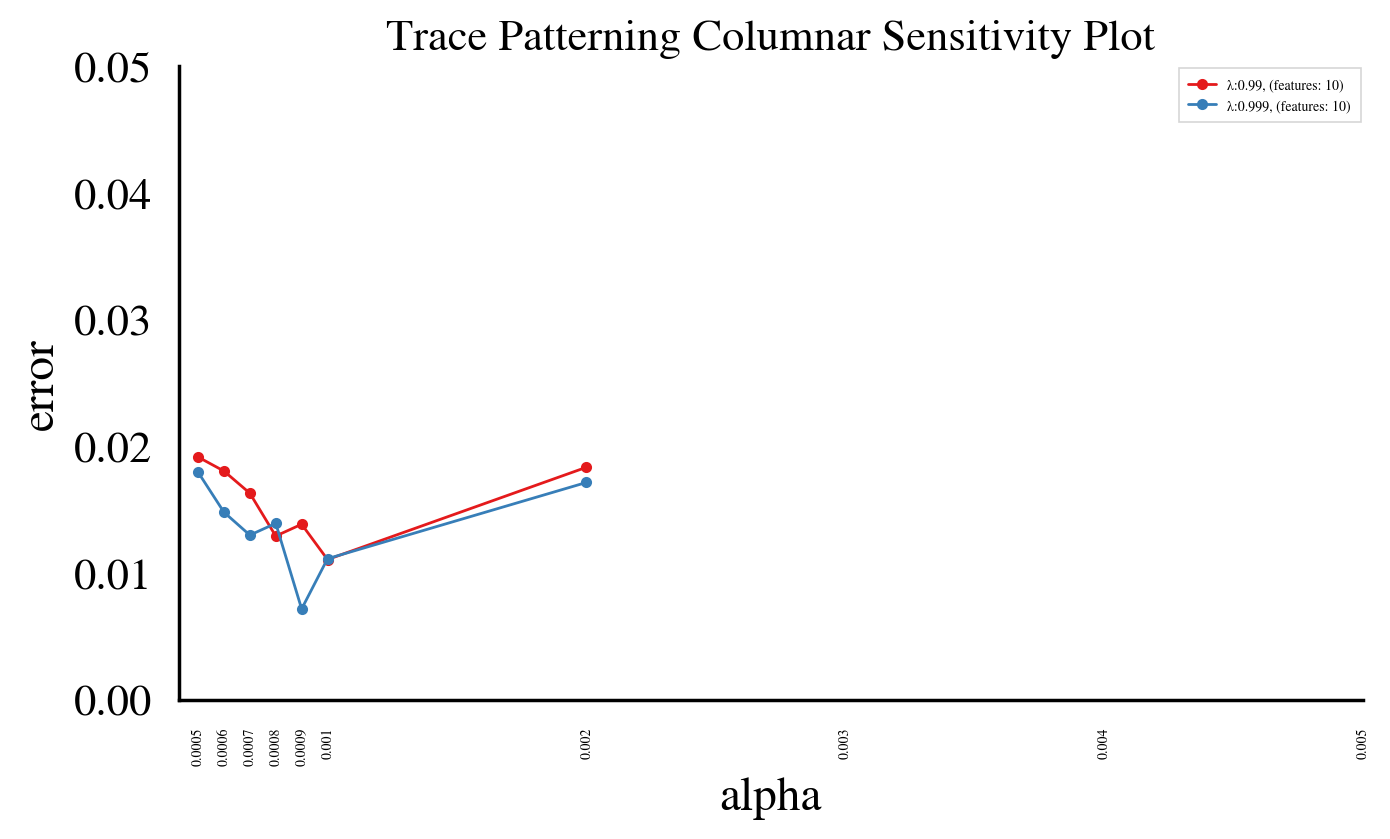

In [53]:
markers = ['.',8,'s','p','*','h']

marker_idx = 0

plt_name = f'Trace Patterning Columnar Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
color_idx = 0
mean_errors = []
runs = pd.read_sql(f'select run, step_size, lambda from runs where width=10 and features=10', db3.conn)
p1 = np.unique(runs.values[:,1])
p2 = np.unique(runs.values[:,2])
for p in itertools.product(p1,p2):
    all_errors = []
    r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
    for run in r["run"].values:
        errors_list = pd.read_sql(f'select error from error_table where run={run}', db3.conn).values
        if len(errors_list) >= 100:
            all_errors.append(errors_list[99][0])
    all_errors = list(filter(lambda v: v==v, all_errors))
    mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
    print(p, ":\t", freq, "\t", all_errors)
#pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
r["run"].values
mean_errors = np.array(mean_errors)

for p in p2:
    values = mean_errors[mean_errors[:,1] == p]
    plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (features: {10})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
    color_idx += 1
marker_idx += 1

plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.show()

(0.0005, 0.99) :	 1000000 	 [0.010878, 0.01147, 0.010179, 0.008014, 0.009398, 0.013688, 0.01212, 0.008098, 0.007538, 0.014903]
(0.0005, 0.999) :	 1000000 	 [0.009324, 0.011334, 0.01018, 0.007859, 0.008635, 0.012394, 0.010993, 0.007268, 0.008576, 0.012804]
(0.0006, 0.99) :	 1000000 	 [0.009493, 0.010843, 0.00992, 0.007459, 0.008845, 0.012441, 0.010575, 0.007248, 0.007818, 0.012788]
(0.0006, 0.999) :	 1000000 	 [0.008113, 0.00969, 0.009966, 0.007634, 0.008095, 0.011578, 0.009019, 0.003904, 0.007538, 0.011352]
(0.0007, 0.99) :	 1000000 	 [0.008621, 0.010245, 0.009556, 0.007402, 0.008525, 0.011858, 0.008358, 0.003528, 0.008024, 0.011189]
(0.0007, 0.999) :	 1000000 	 [0.008491, 0.009409, 0.009533, 0.006564, 0.009226, 0.010929, 0.009136, 0.00422, 0.007201, 0.009826]
(0.0008, 0.99) :	 1000000 	 [0.009525, 0.009919, 0.009354, 0.006764, 0.00834, 0.011261, 0.008411, 0.004727, 0.007537, 0.011603]
(0.0008, 0.999) :	 1000000 	 [0.007677, 0.009263, 0.009285, 0.008699, 0.00856, 0.01006, 0.009099, 0.0

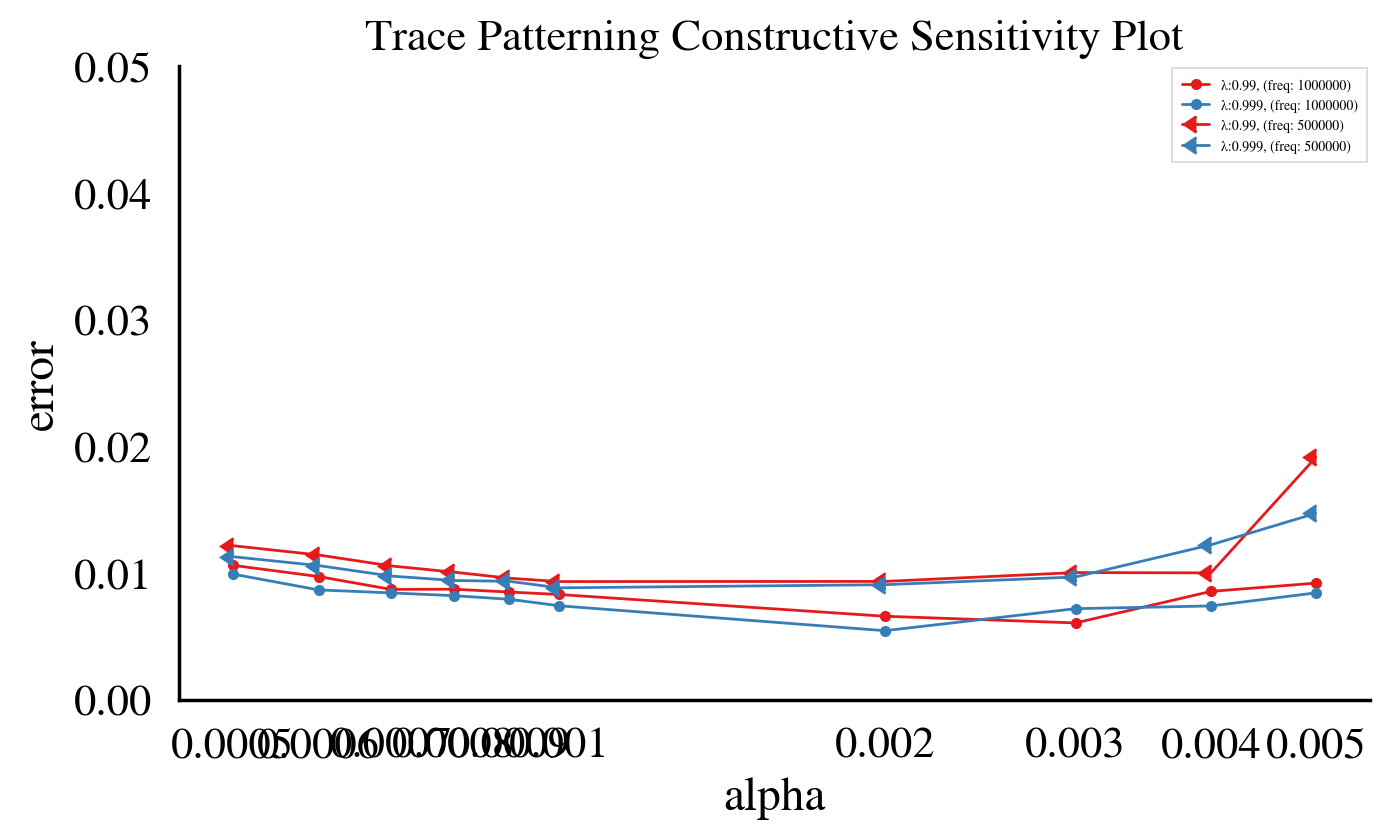

In [38]:
markers = ['.',8,'s','p','*','h']

marker_idx = 0

plt_name = f'Trace Patterning Constructive Sensitivity Plot'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for freq in pd.read_sql(f'select distinct(freq) from runs where width=1', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width=1 and freq={freq}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 100:
                all_errors.append(errors_list[99][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", freq, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (freq: {freq})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
        color_idx += 1
    marker_idx += 1

plt.xscale('log')
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.show()

In [17]:
for f in pd.read_sql(f'select distinct(freq) from runs where width={width}', db1.conn).values:
    print(f)

[800000]


In [39]:
pd.read_sql(f'select run from runs where width={3}', db1.conn)
len(pd.read_sql(f'select * from error_table where run=3899', db1.conn).values.squeeze())

42

(0.0005, 0.99) :	 3 	 [0.006472, 0.008715, 0.011021, 0.007454, 0.008251, 0.006428, 0.00817, 0.005418, 0.008433, 0.011517]
(0.0005, 0.999) :	 3 	 [0.005234, 0.007002, 0.009788, 0.006188, 0.006887, 0.006682, 0.007217, 0.006743, 0.009032, 0.008313]
(0.0006, 0.99) :	 3 	 [0.005899, 0.005947, 0.009294, 0.005874, 0.006502, 0.006552, 0.007314, 0.003695, 0.008812, 0.008363]
(0.0006, 0.999) :	 3 	 [0.005033, 0.003532, 0.007392, 0.006574, 0.005798, 0.007696, 0.008059, 0.003497, 0.007785, 0.006596]
(0.0007, 0.99) :	 3 	 [0.004932, 0.002924, 0.007838, 0.00669, 0.00656, 0.007765, 0.006656, 0.003398, 0.006494, 0.007373]
(0.0007, 0.999) :	 3 	 [0.003727, 0.003156, 0.006237, 0.006207, 0.005605, 0.007378, 0.005153, 0.003412, 0.00628, 0.006281]
(0.0008, 0.99) :	 3 	 [0.003456, 0.002785, 0.008385, 0.006406, 0.005047, 0.007372, 0.007451, 0.004705, 0.005568, 0.005133]
(0.0008, 0.999) :	 3 	 [0.003004, 0.004727, 0.00787, 0.005825, 0.005089, 0.004925, 0.004292, 0.002638, 0.003774, 0.005223]
(0.0009, 0.99) :	

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.005, 0.999) :	 5 	 []
(0.0005, 0.99) :	 2 	 [0.009304, 0.010472, 0.011699, 0.010077, 0.008875, 0.011152, 0.008398, 0.006159, 0.008062, 0.009697]
(0.0005, 0.999) :	 2 	 [0.007903, 0.008912, 0.011115, 0.009156, 0.008409, 0.010717, 0.0073, 0.00566, 0.007616, 0.007304]
(0.0006, 0.99) :	 2 	 [0.007657, 0.009482, 0.011179, 0.00902, 0.008239, 0.011412, 0.006892, 0.004112, 0.007257, 0.008333]
(0.0006, 0.999) :	 2 	 [0.005589, 0.006773, 0.010933, 0.006832, 0.008021, 0.009929, 0.006257, 0.003529, 0.00683, 0.005782]
(0.0007, 0.99) :	 2 	 [0.006067, 0.00726, 0.01093, 0.008216, 0.007632, 0.009204, 0.006079, 0.003645, 0.006963, 0.005748]
(0.0007, 0.999) :	 2 	 [0.005837, 0.005076, 0.010995, 0.006074, 0.007519, 0.009737, 0.003545, 0.003152, 0.006743, 0.00708]
(0.0008, 0.99) :	 2 	 [0.005616, 0.004375, 0.010388, 0.007132, 0.006597, 0.009287, 0.003061, 0.003277, 0.006898, 0.006825]
(0.0008, 0.999) :	 2 	 [0.005508, 0.006171, 0.009063, 0.007133, 0.008354, 0.008467, 0.002823, 0.003089, 0.007039, 0.005

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.004, 0.999) :	 10 	 []
(0.005, 0.99) :	 10 	 []
(0.005, 0.999) :	 10 	 []


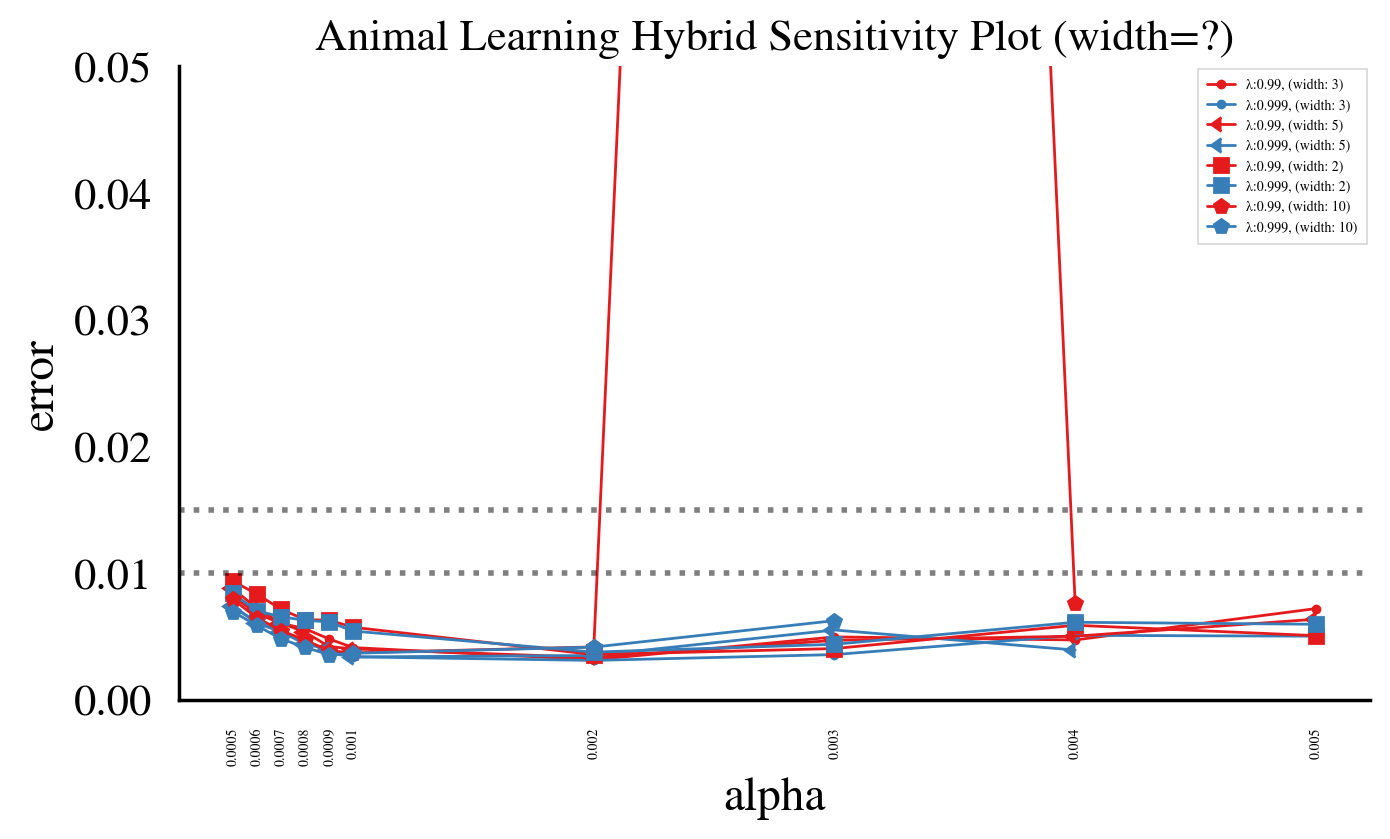

In [40]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=10

plt_name = f'Animal Learning Hybrid Sensitivity Plot (width=?)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

for width in pd.read_sql(f'select distinct(width) from runs where width!=1', db1.conn).values.squeeze():
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where width={width}', db1.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db1.conn).values
            if len(errors_list) >= 100:
                all_errors.append(errors_list[99][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        if (all_errors != [None]):
            mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t", width, "\t", all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[42]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, (width: {width})", color=colors[color_idx], linewidth=1, marker=markers[marker_idx], markersize=5)
        color_idx += 1
    marker_idx += 1

plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.axhline(y=0.01, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.show()

In [31]:
pd.read_sql(f'select distinct(features) from runs where truncation=27', db2.conn).values.squeeze()

array([ 2,  5, 10, 20])

(0.0007, 0.99) :	 f: 2 [0.017942, 0.018049, 0.02099, 0.018921, 0.021907, 0.021677]
(0.0007, 0.999) :	 f: 2 [0.017938, 0.01805, 0.020992, 0.018922, 0.021907, 0.021678]
(0.0008, 0.99) :	 f: 2 [0.017937, 0.018047, 0.020994, 0.018921, 0.021911, 0.021679, 0.018312, 0.020216, 0.019742, 0.020176]
(0.0008, 0.999) :	 f: 2 [0.017932, 0.018047, 0.020997, 0.018922, 0.021911, 0.021681, 0.018309, 0.020217, 0.01974, 0.020177]
(0.0009, 0.99) :	 f: 2 [0.017932, 0.018045, 0.020999, 0.018921, 0.021915, 0.021681, 0.018312, 0.020218, 0.019743, 0.020177]
(0.0009, 0.999) :	 f: 2 [0.017926, 0.018046, 0.021001, 0.018922, 0.021914, 0.021683, 0.018307, 0.020219, 0.019741, 0.020177]
(0.001, 0.99) :	 f: 2 [0.017928, 0.018044, 0.021002, 0.018921, 0.021918, 0.021684, 0.018311, 0.02022, 0.019743, 0.020178]
(0.001, 0.999) :	 f: 2 [0.01792, 0.018044, 0.021004, 0.018922, 0.021917, 0.021685, 0.018306, 0.020221, 0.019741, 0.020179]
(0.002, 0.99) :	 f: 2 [0.017871, 0.018037, 0.021009, 0.018914, 0.021913, 0.021692, 0.018297

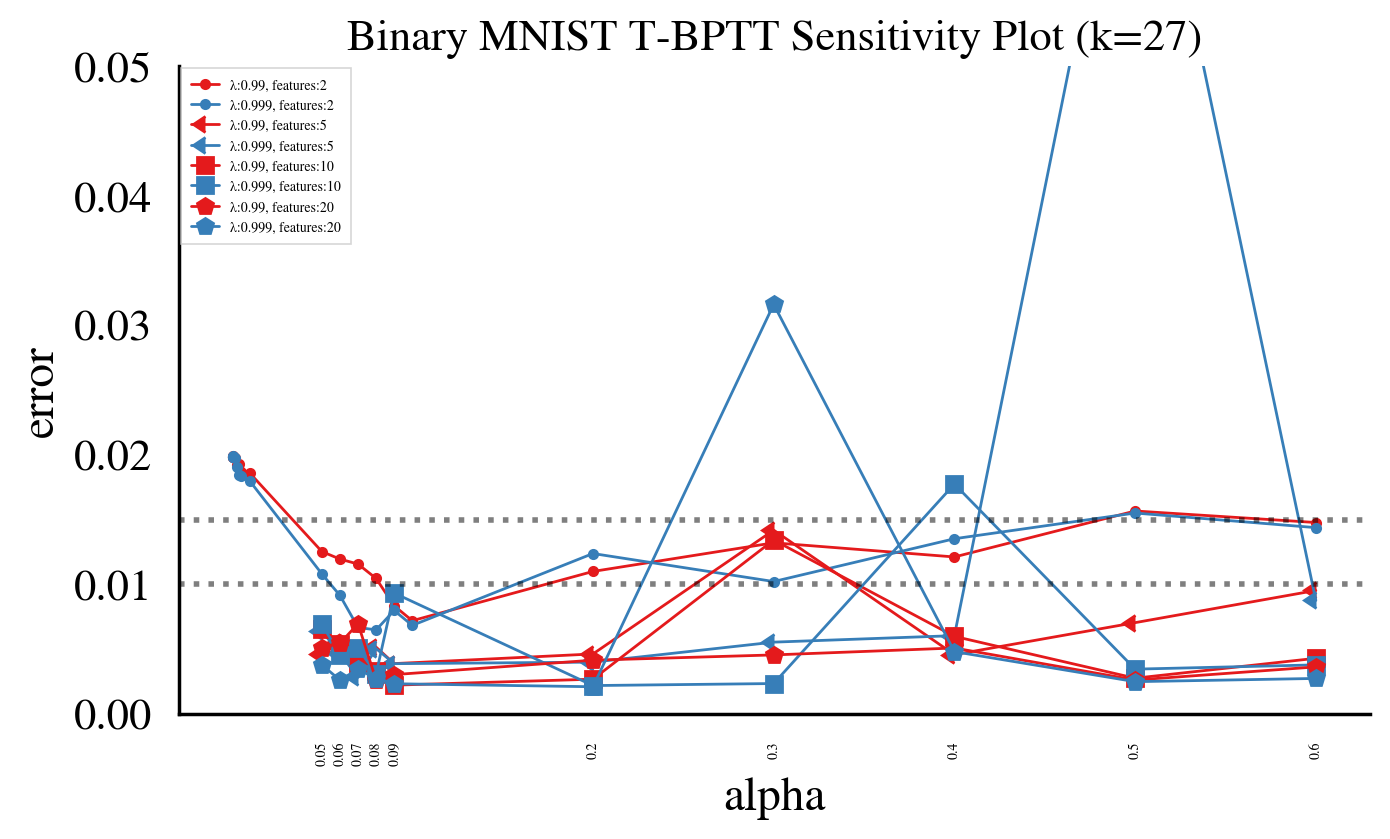

In [37]:
markers = ['.',8,'s','p','*','h']
marker_idx = 0
width=20

plt_name = f'Binary MNIST T-BPTT Sensitivity Plot (k=27)'
fig = plt.figure(dpi=200)
plt.title(plt_name)
plt.xlabel('alpha')
plt.ylabel('error')

features = pd.read_sql(f'select distinct(features) from runs where truncation=27', db2.conn).values.squeeze()
for feature in features:
    colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
    color_idx = 0
    mean_errors = []
    runs = pd.read_sql(f'select run, step_size, lambda from runs where features={feature}', db2.conn)
    p1 = np.unique(runs.values[:,1])
    p2 = np.unique(runs.values[:,2])
    for p in itertools.product(p1,p2):
        all_errors = []
        r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
        for run in r["run"].values:
            errors_list = pd.read_sql(f'select error from error_table where run={run}', db2.conn).values
            if len(errors_list) >= 100:
                all_errors.append(errors_list[99][0])
        all_errors = list(filter(lambda v: v==v, all_errors))
        mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
        print(p, ":\t f:", feature, all_errors)
    #pd.read_sql(f'select error from error_table where run=0', db2.conn).values[400]
    r["run"].values
    mean_errors = np.array(mean_errors)

    for p in p2:
        values = mean_errors[mean_errors[:,1] == p]
        plt.plot(values[:,0], values[:,2], label=f"λ:{p}, features:{feature}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])
        color_idx += 1
    marker_idx += 1

plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
plt.xticks(values[:,0], values[:,0])
fig.axes[0].set_ylim(bottom=0.00, top=0.05)
legend = plt.legend(prop={'size': 5})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.6)
frame.set_boxstyle('Square')
plt.axhline(y=0.015, color='black', linestyle=':', linewidth=2, alpha=0.5)
plt.axhline(y=0.01, color='black', linestyle=':', linewidth=2, alpha=0.5)

plt.show()

	 Found 10 valid runs for [['step_size', 0.08], ['lambda', 0.999], ['features', 2]]
	 Found 10 valid runs for [['step_size', 0.07], ['lambda', 0.999], ['features', 5]]
	 Found 10 valid runs for [['width', 10], ['lambda', 0.999], ['step_size', 0.0009]]
	 Found 10 valid runs for [['width', 1], ['lambda', 0.999], ['step_size', 0.002], ['freq', 1000000]]
	 Found 10 valid runs for [['width', 2], ['lambda', 0.99], ['step_size', 0.002]]


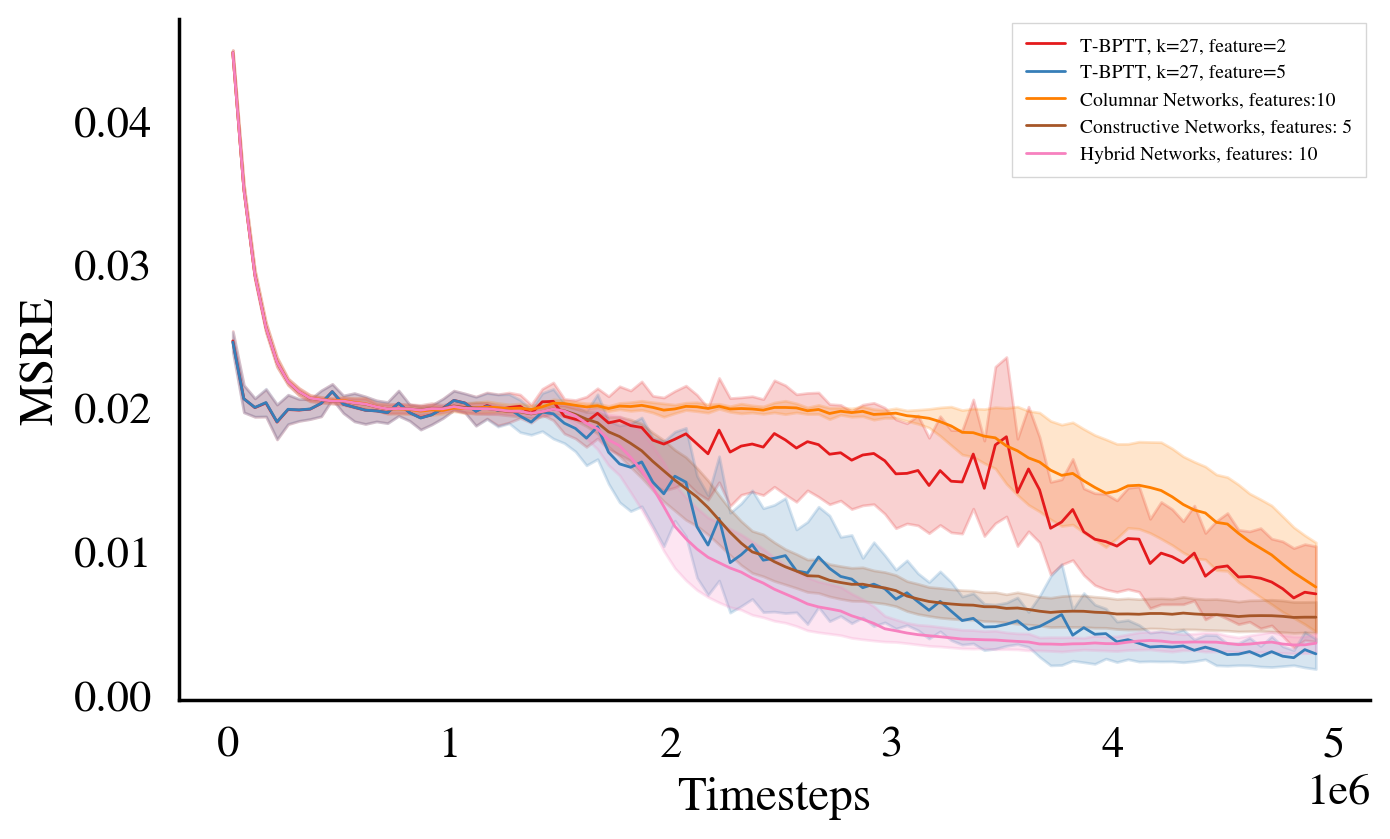

In [56]:

plt_name = f'Binary MNIST Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['step_size', 0.08],
              ['lambda', 0.999],
              ['features', 2]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.07],
              ['lambda', 0.999],
              ['features', 5]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.2],
              ['lambda', 0.999],
              ['features', 10]]
#plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.09],
              ['lambda', 0.999],
              ['features', 20]]
#plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=20", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#conditions = [['lambda', 0.99],
#             ['step_size', 1e-2]]
#plt_with_err("", 98, 4500000, db4, colors[color_idx], "SnAp-1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
#color_idx+=1

conditions = [['width', 10],
             ['lambda', 0.999],
             ['step_size', 0.0009]]
plt_with_err("", 99,0, db3, colors[color_idx], "Columnar Networks, features:10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=2

conditions = [['width', 1],
             ['lambda', 0.999],
             ['step_size', 0.002],
             ['freq', 1000000]]
plt_with_err("", 99,0, db1, colors[color_idx], "Constructive Networks, features: 5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 2],
             ['lambda', 0.99],
             ['step_size', 0.002]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 3],
             ['lambda', 0.999],
             ['step_size', 0.001]]
#plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 15", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 10],
             ['lambda', 0.999],
             ['step_size', 0.0009]]
#plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 100", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['step_size', 0.08], ['lambda', 0.999], ['features', 2]]
	 Found 10 valid runs for [['step_size', 0.09], ['lambda', 0.999], ['features', 5]]
	 Found 10 valid runs for [['width', 1], ['lambda', 0.999], ['step_size', 0.002], ['freq', 500000]]
	 Found 10 valid runs for [['width', 2], ['lambda', 0.99], ['step_size', 0.002]]
	 Found 10 valid runs for [['width', 3], ['lambda', 0.999], ['step_size', 0.001]]


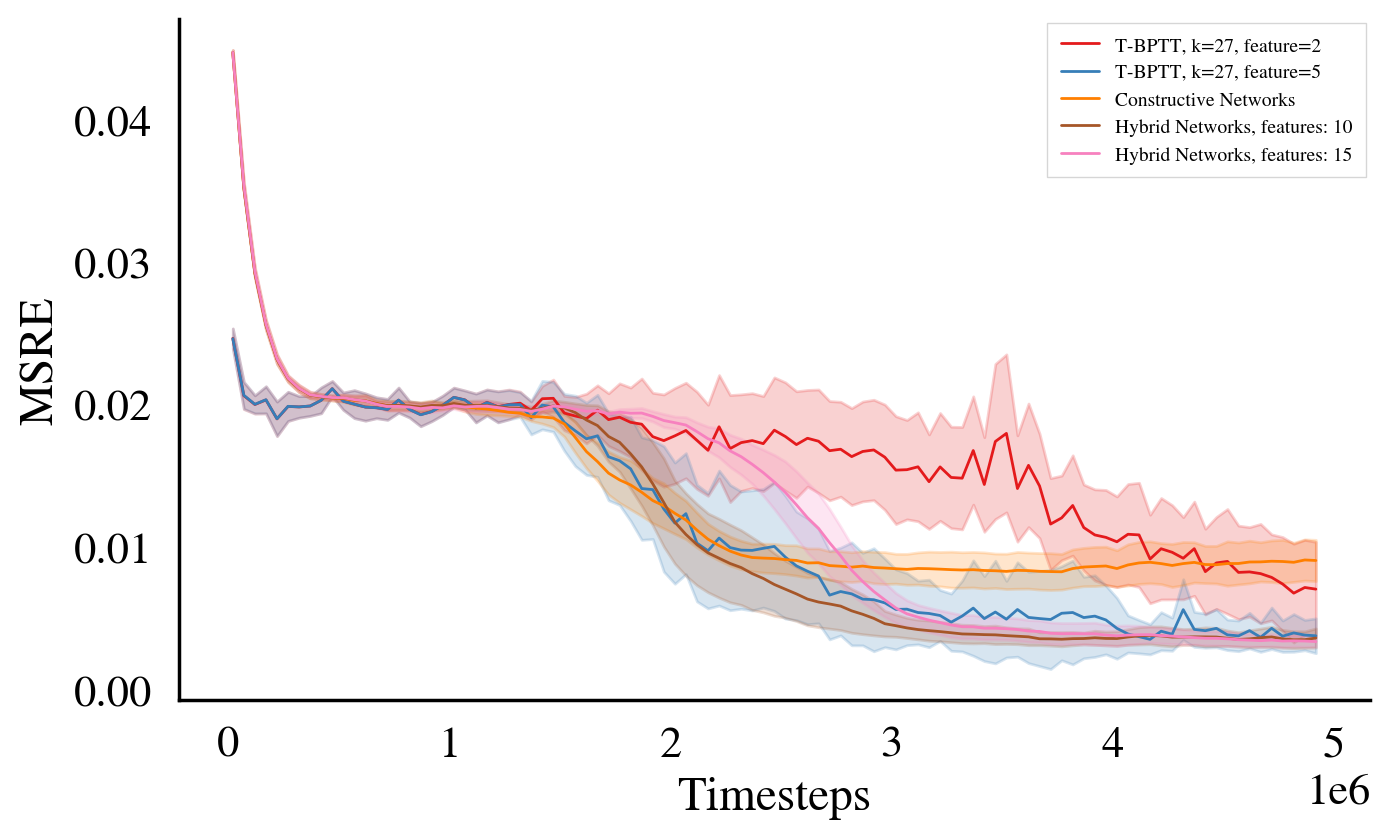

In [45]:

plt_name = f'Binary MNIST Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['step_size', 0.08],
              ['lambda', 0.999],
              ['features', 2]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.09],
              ['lambda', 0.999],
              ['features', 5]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.2],
              ['lambda', 0.999],
              ['features', 10]]
#plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.09],
              ['lambda', 0.999],
              ['features', 20]]
#plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=20", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#conditions = [['lambda', 0.99],
#             ['step_size', 1e-2]]
#plt_with_err("", 98, 4500000, db4, colors[color_idx], "SnAp-1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
#color_idx+=1

#conditions = [['width', 200],
#             ['lambda', 0.99],
#             ['step_size', 0.003]]
#plt_with_err("", 100,0, db1, colors[color_idx], "Columnar Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
#color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.999],
             ['step_size', 0.002],
             ['freq', 500000]]
plt_with_err("", 99,0, db1, colors[color_idx], "Constructive Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=2

conditions = [['width', 2],
             ['lambda', 0.99],
             ['step_size', 0.002]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 3],
             ['lambda', 0.999],
             ['step_size', 0.001]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 15", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 10],
             ['lambda', 0.999],
             ['step_size', 0.0009]]
#plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 100", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['step_size', 0.08], ['lambda', 0.999], ['features', 2]]
	 Found 10 valid runs for [['step_size', 0.09], ['lambda', 0.999], ['features', 5]]
	 Found 10 valid runs for [['step_size', 0.2], ['lambda', 0.999], ['features', 10]]
	 Found 10 valid runs for [['step_size', 0.09], ['lambda', 0.999], ['features', 20]]
	 Found 10 valid runs for [['width', 1], ['lambda', 0.999], ['step_size', 0.002], ['freq', 500000]]
	 Found 10 valid runs for [['width', 2], ['lambda', 0.99], ['step_size', 0.002]]
	 Found 10 valid runs for [['width', 3], ['lambda', 0.999], ['step_size', 0.001]]
	 Found 10 valid runs for [['width', 10], ['lambda', 0.999], ['step_size', 0.0009]]


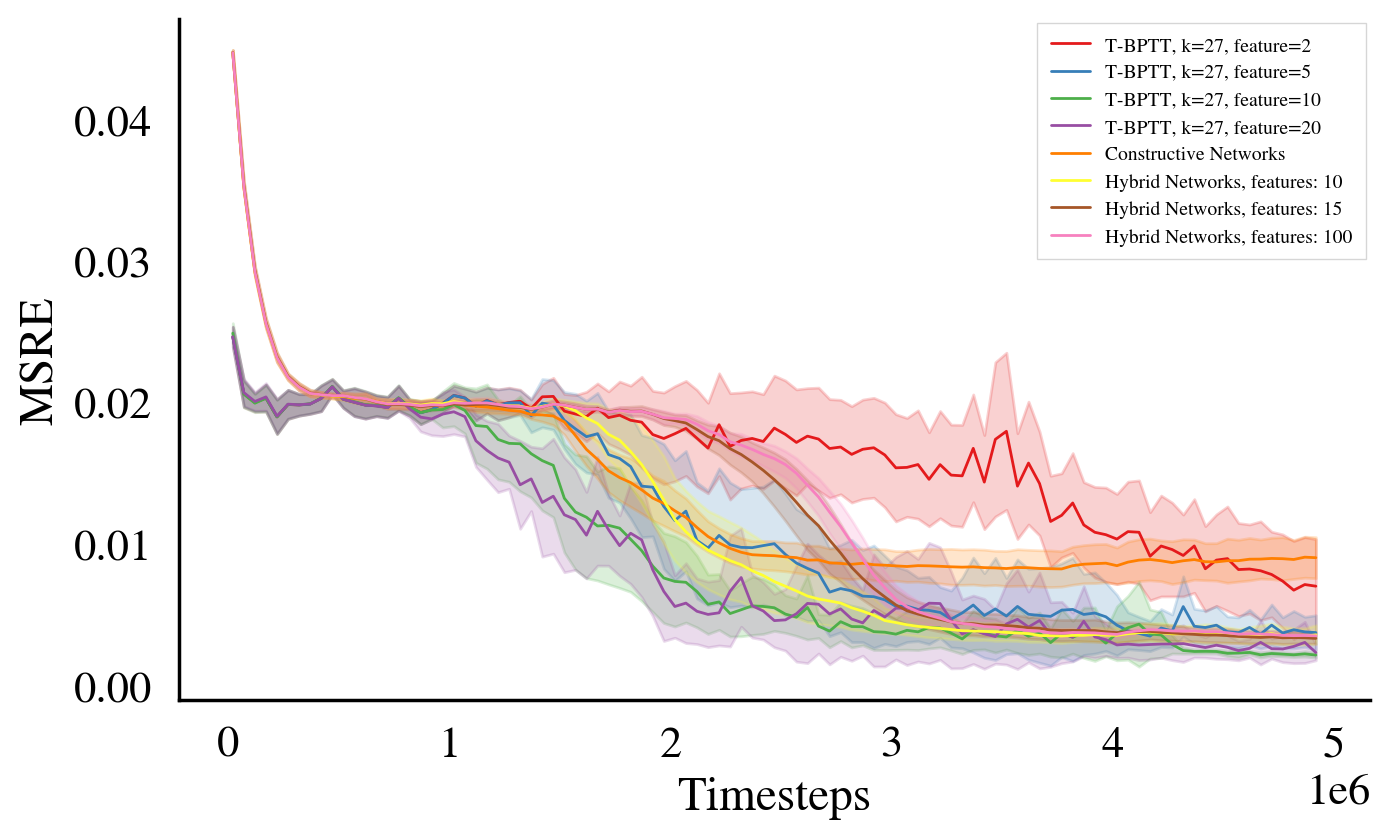

In [13]:

plt_name = f'Binary MNIST Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['step_size', 0.08],
              ['lambda', 0.999],
              ['features', 2]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.09],
              ['lambda', 0.999],
              ['features', 5]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.2],
              ['lambda', 0.999],
              ['features', 10]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1
conditions = [['step_size', 0.09],
              ['lambda', 0.999],
              ['features', 20]]
plt_with_err("", 99, 0, db2, colors[color_idx], "T-BPTT, k=27, feature=20", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#conditions = [['lambda', 0.99],
#             ['step_size', 1e-2]]
#plt_with_err("", 98, 4500000, db4, colors[color_idx], "SnAp-1", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
#color_idx+=1

#conditions = [['width', 200],
#             ['lambda', 0.99],
#             ['step_size', 0.003]]
#plt_with_err("", 100,0, db1, colors[color_idx], "Columnar Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
#color_idx+=1

conditions = [['width', 1],
             ['lambda', 0.999],
             ['step_size', 0.002],
             ['freq', 500000]]
plt_with_err("", 99,0, db1, colors[color_idx], "Constructive Networks", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 2],
             ['lambda', 0.99],
             ['step_size', 0.002]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 3],
             ['lambda', 0.999],
             ['step_size', 0.001]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 15", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

conditions = [['width', 10],
             ['lambda', 0.999],
             ['step_size', 0.0009]]
plt_with_err("", 99,0, db1, colors[color_idx], "Hybrid Networks, features: 100", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=1)
color_idx+=1

#plt.axhline(y=0.95, color='black', linestyle=':', linewidth=2, alpha=0.5)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [22]:
def plot_last_n_paper(obsall, predall, targets, n=400, colortarget=None, colorpred=None):
    fig, axs = plt.subplots(2,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()#(7.2,4.45)
    axs[-2].step(list(range(n)), targets[-n:], color=colortarget)
    axs[-1].step(list(range(n)), predall[-n:], color=colorpred)
    axs[-2].set_ylabel('Target')
    axs[-1].set_ylabel('Prediction')
    axs[-1].set_xlabel('Timestep')

    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
    return fig

In [16]:
def plot_last_n_paper(n=400, db=None, condition=None, colortarget=None, colorpred=None, axs=None, seed=0):
    # too lazy
    seed = seed
    pkey_col = 'run'
    if condition == []:
        r = pd.read_sql(f'select {pkey_col} from runs and seed=0', db.conn).values
    elif len(condition) == 1:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and seed={seed}', db.conn).values
    elif len(condition) == 2:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and seed={seed}', db.conn).values
    elif len(condition) == 3:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and seed={seed}', db.conn).values
    elif len(condition) == 4:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and seed={seed}', db.conn).values
    run = r[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db.conn)
    #obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,-2]
    target = pred_table.values[:,-1]

    axs.step(list(range(n)), target[-n:], color=colortarget, alpha=0.2)
    axs.step(list(range(n)), pred[-n:], color=colorpred)
    #axs.set_ylabel('Target')
    #axs.set_ylabel('Prediction')
    #axs.set_xlabel('Timestep')

    #for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
    #    ax.label_outer()
    return fig, pred, target

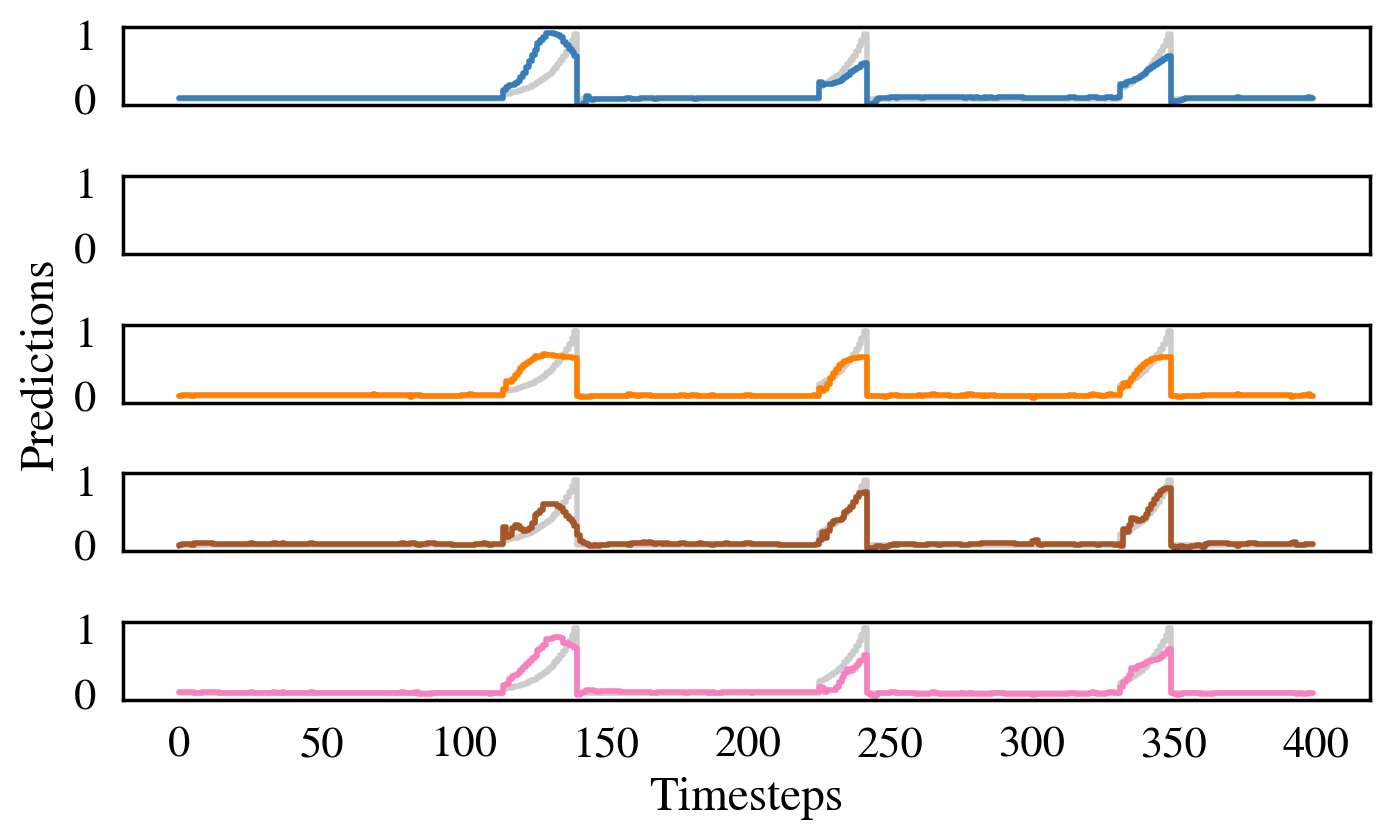

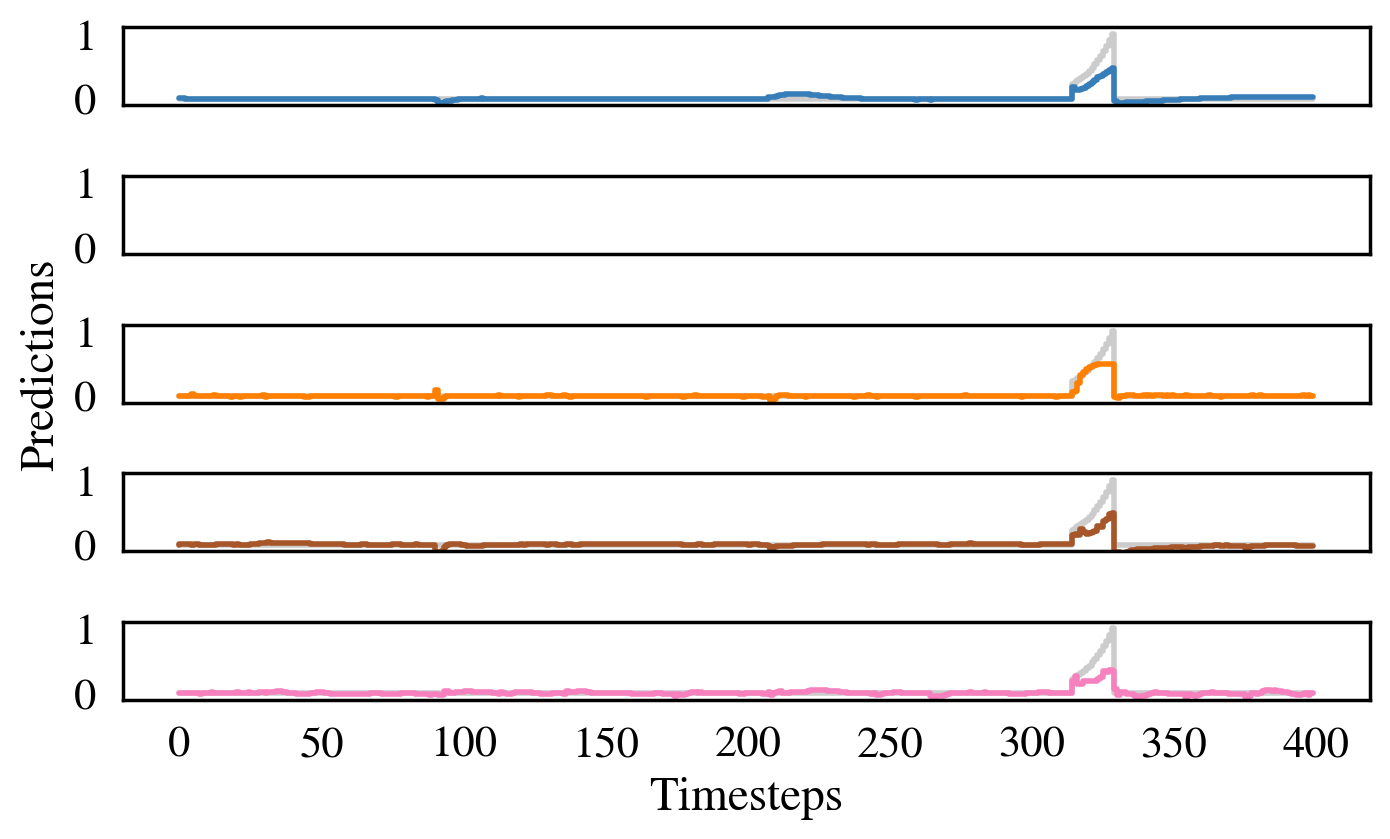

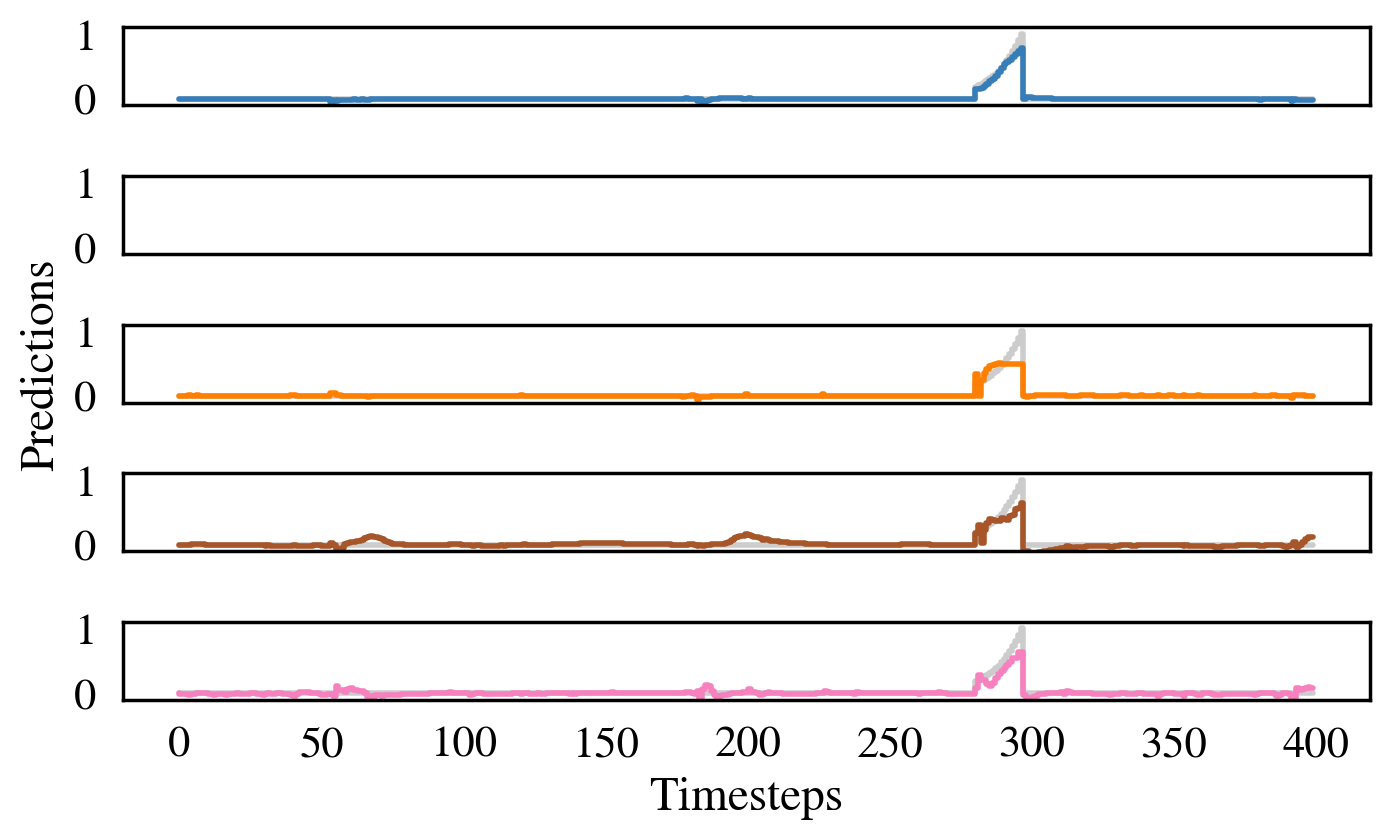

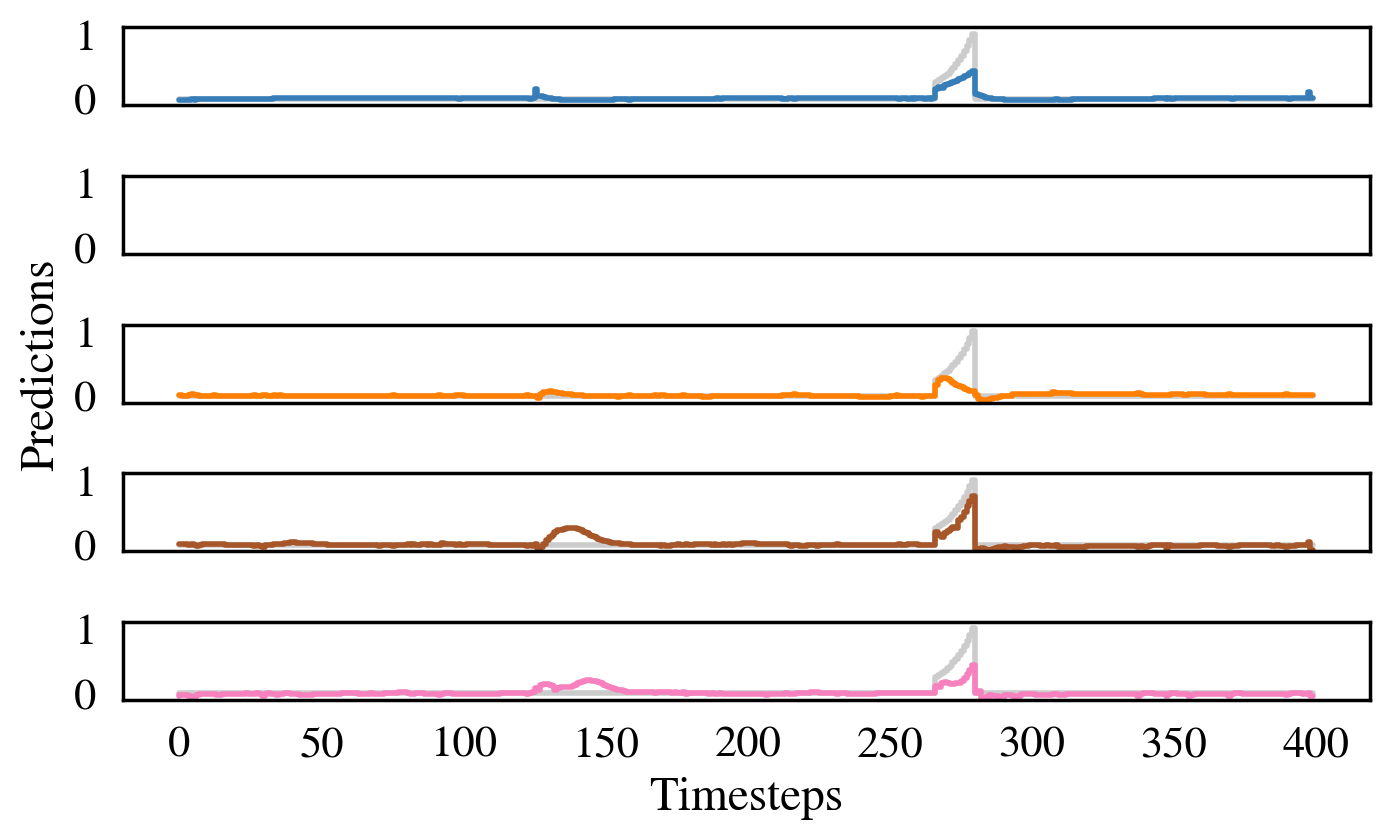

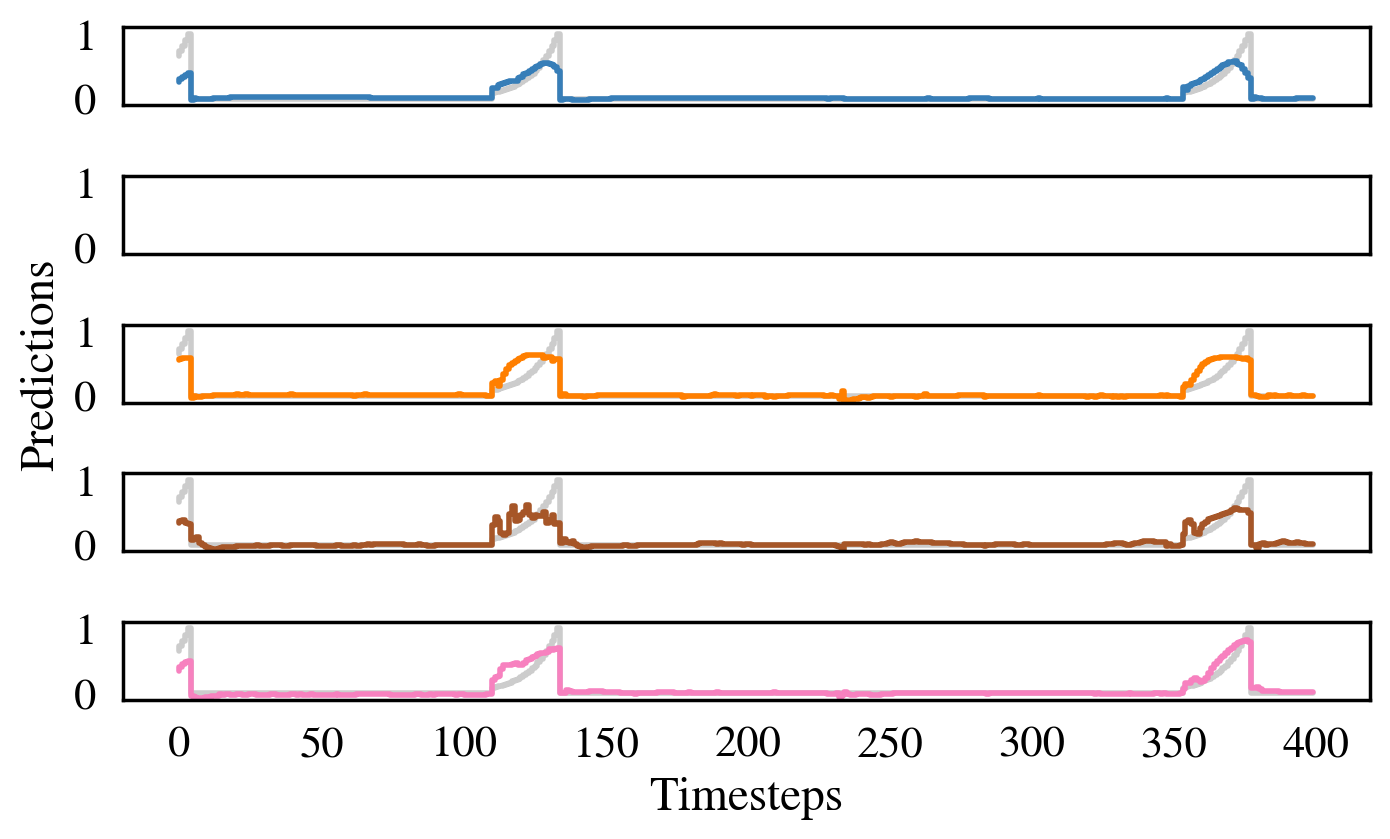

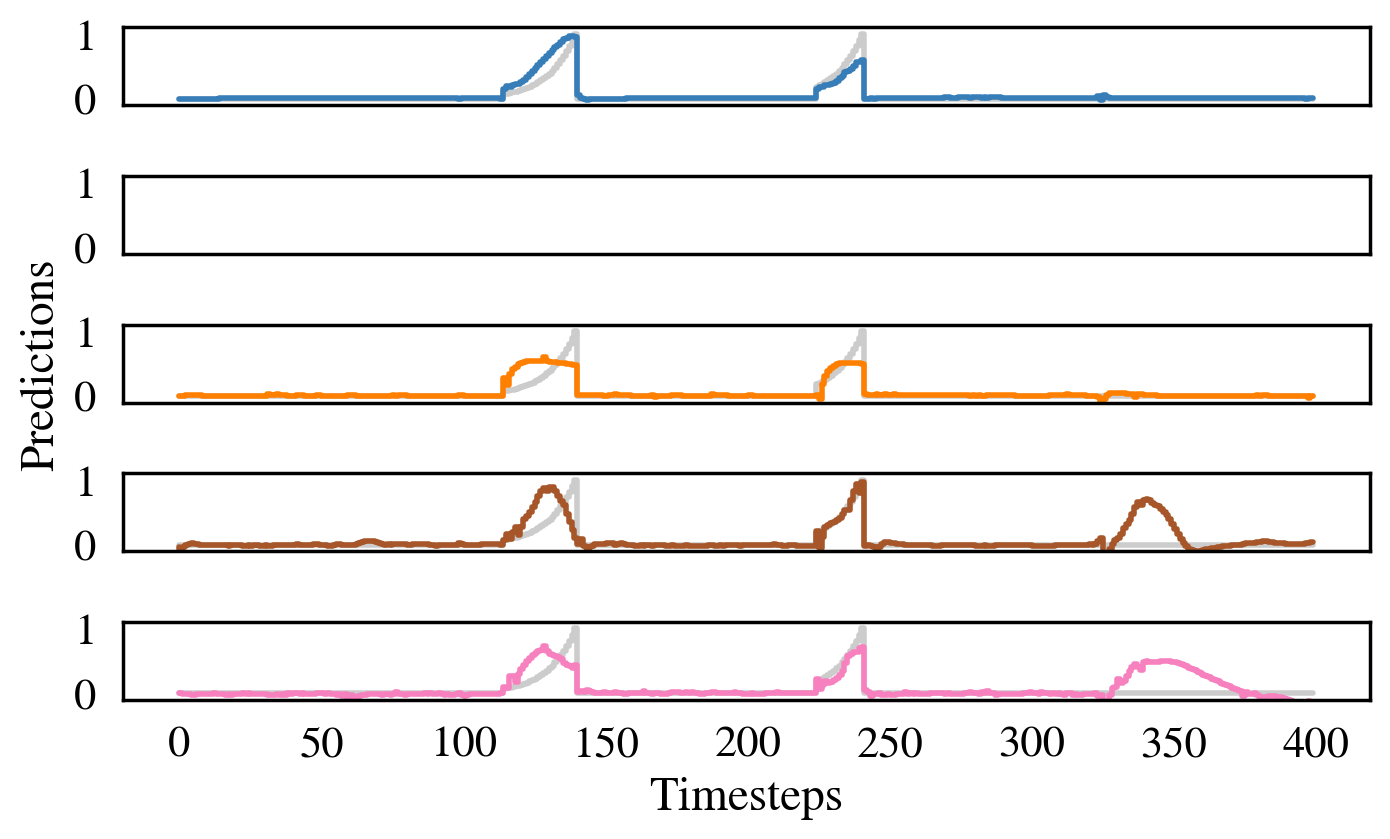

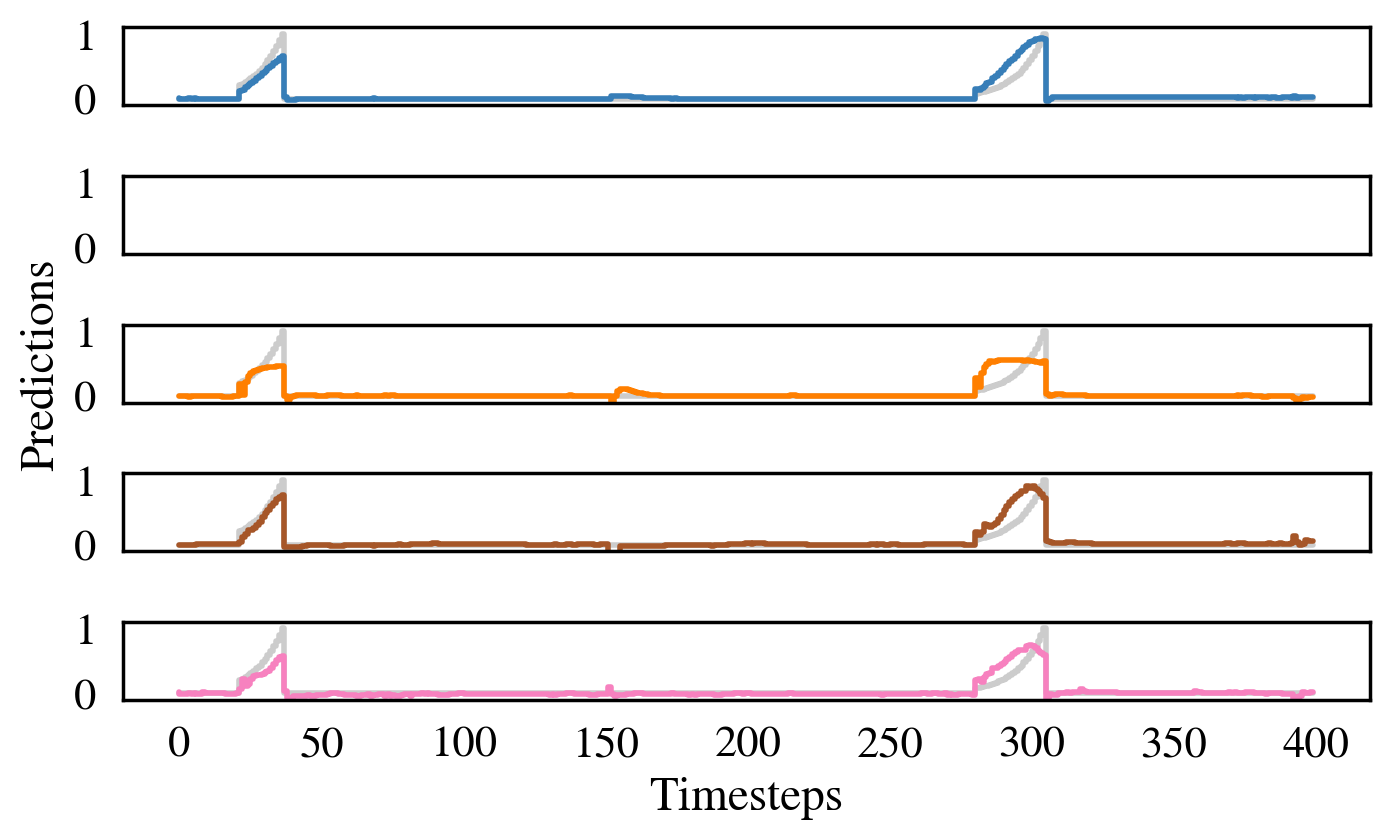

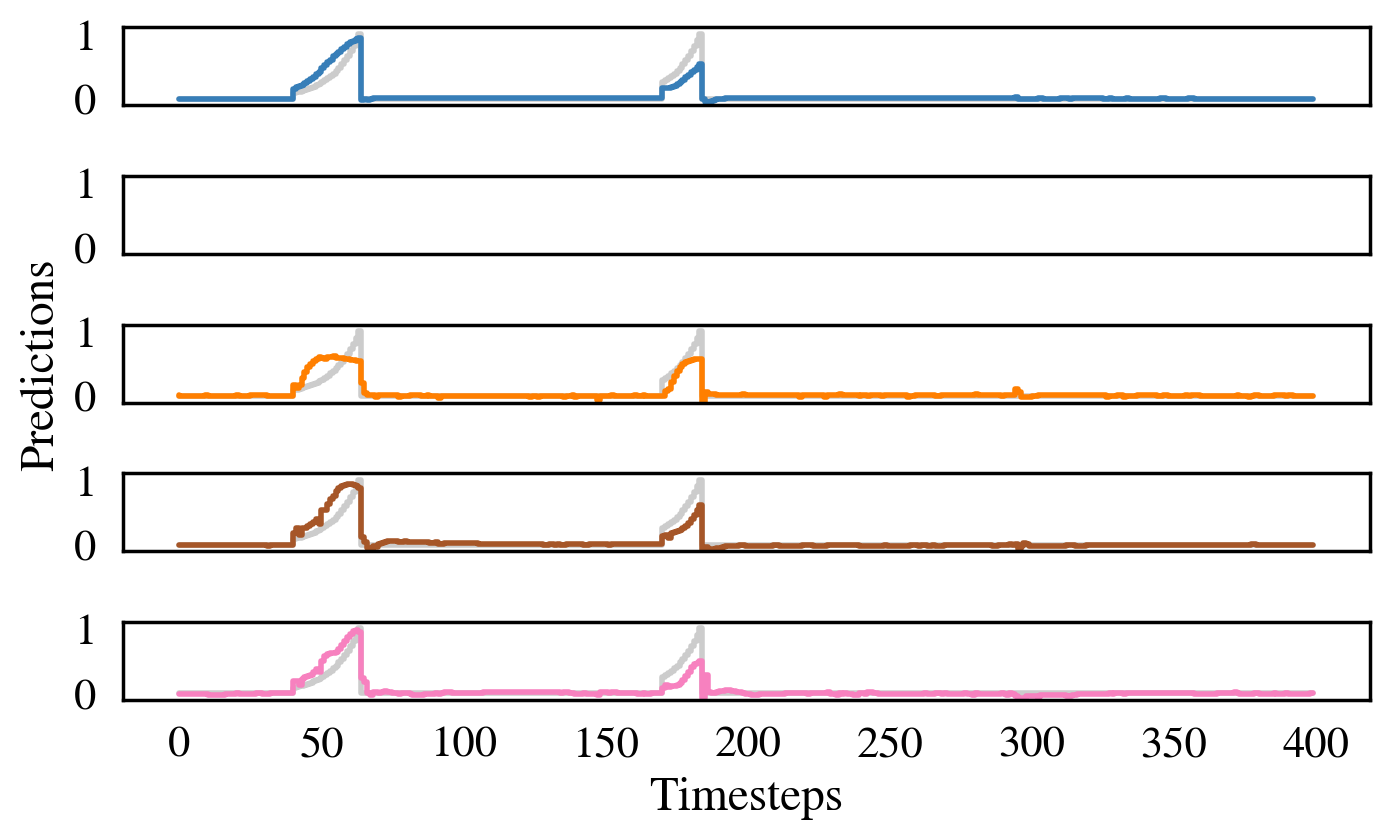

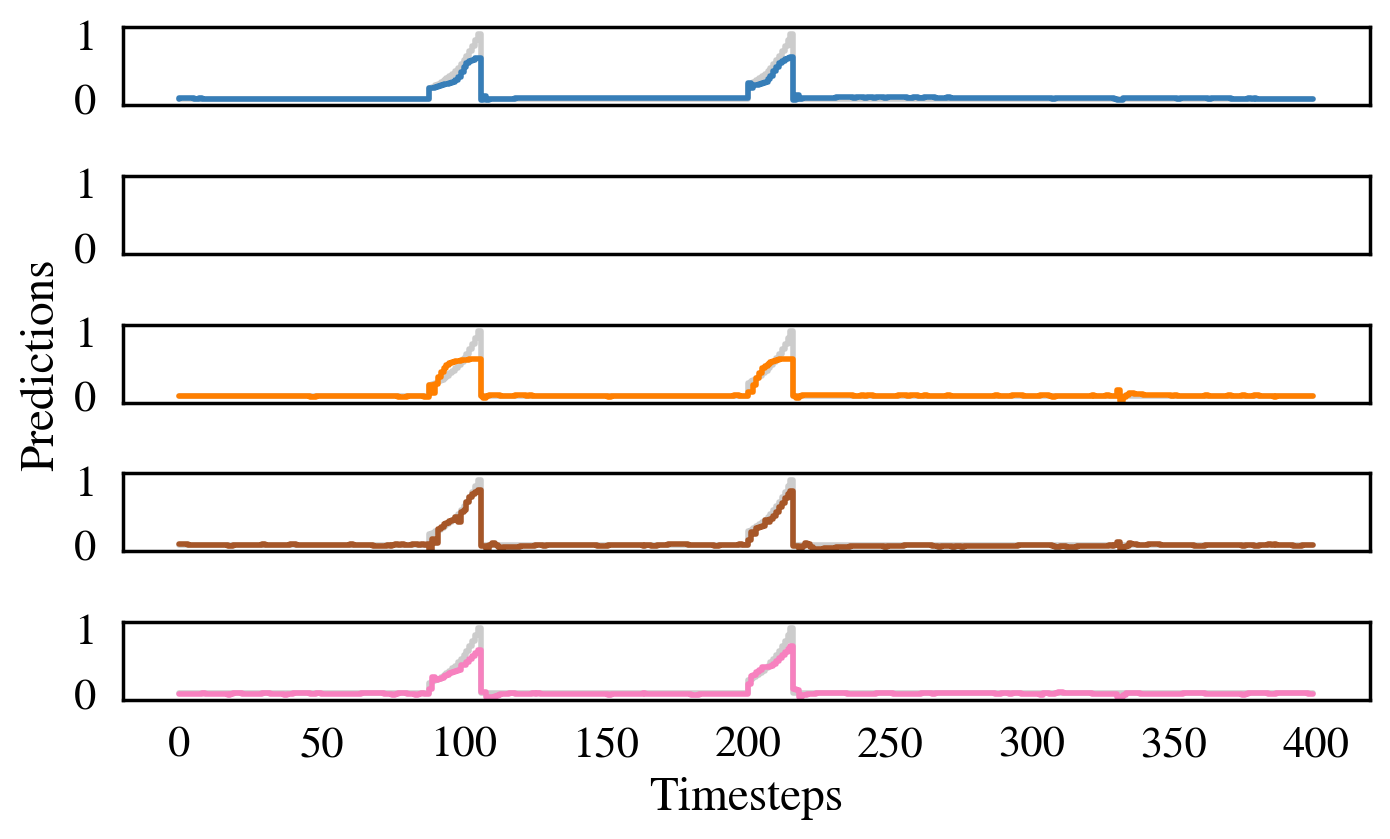

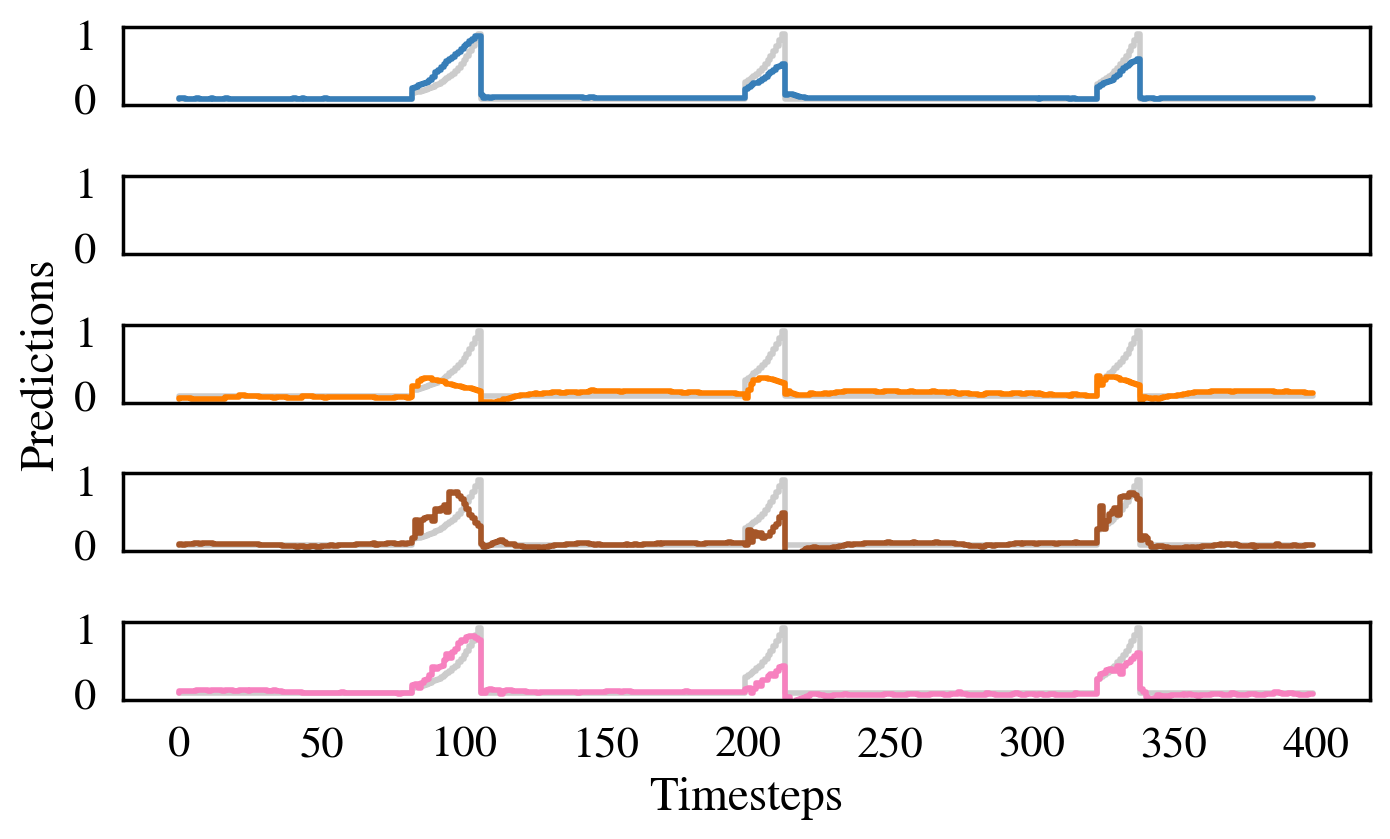

In [18]:
colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']

for seed in [0,1,2,3,4,5,6,7,8,9]:
    fig, axs = plt.subplots(5,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()
    """
    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 1e-2],
                 ['freq', 800000]]
    colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
    run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
    obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,9]
    target = pred_table.values[:,10]
    plot_last_n_paper(obs, pred, target, colortarget=colors[6], colorpred=colors[4], axs=axs[0])
    plot_last_n_paper(obs, pred, target, colortarget=colors[7], colorpred=colors[4], axs=axs[1])
    #plt.suptitle('Hybrid NNs')
    """

    color_idx = 1

    conditions = [['step_size', 0.09],
                  ['lambda', 0.999],
                  ['features', 5]]
    plot_last_n_paper(db=db2, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[0], seed=seed)
    color_idx+=1

    #conditions = [['lambda', 0.99],
    #             ['step_size', 1e-2]]
    #plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[1])
    color_idx+=2

    conditions = [['width', 10],
                 ['lambda', 0.999],
                 ['step_size', 0.0009]]
    plot_last_n_paper(db=db3, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[2], seed=seed)
    color_idx+=2

    conditions = [['width', 1],
                 ['lambda', 0.999],
                 ['step_size', 0.002],
                 ['freq', 1000000]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[3], seed=seed)
    color_idx+=1

    conditions = [['width', 2],
                 ['lambda', 0.99],
                 ['step_size', 0.002]]
    plot_last_n_paper(db=db1, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[4], seed=seed)
    color_idx+=1
    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    axs[2].set_ylabel("Predictions")
    plt.xlabel("Timesteps")
    plt.savefig('figures/plt_mnist_preds.svg', bbox_inches='tight')